In [49]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [50]:
import numpy as np
import pandas as pd

In [51]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [52]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [53]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [54]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [55]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [56]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [57]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

([], <a list of 0 Text xticklabel objects>)

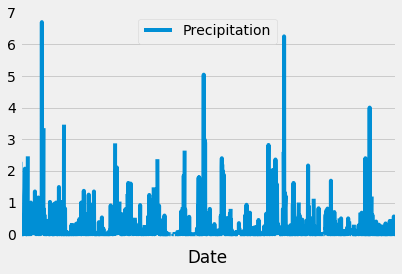

In [58]:
# year = dt.datetime.strptime(date[0][0],"%Y-%m-%d").year
# month = dt.datetime.strptime(date[0][0],"%Y-%m-%d").month
# day = dt.datetime.strptime(date[0][0],"%Y-%m-%d").day

# Design a query to retrieve the last 12 months of precipitation data and plot the results
max_date = session.execute('select MAX(date) from measurement').fetchall()
max_date = max_date[0][0]

# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
date_stamp = dt.datetime.strptime(max_date,'%Y-%m-%d')
year = date_stamp.year
month = date_stamp.month
day = date_stamp.day

prior_year = f'{year-1}-{month:02d}-{day:02d}'

#prcp_data = session.execute(f"select date, prcp from measurement where date BETWEEN '{year-1}-{month:02d}-{day:02d}' AND '{year}-{month:02d}-{day:02d}'").fetchall()
prcp_data = session.execute(f"select date, prcp from measurement where date > '{prior_year}'").fetchall()


# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data)
prcp_df = prcp_df.rename(columns={0:'Date', 1:'Precipitation'})
prcp_df = prcp_df.set_index('Date')
# prcp_df= prcp_df.dropna()

# Sort the dataframe by date
prcp_df = prcp_df.sort_values(by='Date')

prcp_df.plot()
plt.xticks([])

![precipitation](Images/precipitation.png)

In [59]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()


,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [60]:
# Design a query to show how many stations are available in this dataset?
station_data = session.execute('Select count(*) from station').fetchall()
print(f"Station Count = {station_data[0][0]}")


Station Count = 9


In [61]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.execute('select station, count(*) from measurement group by station order by count(station) desc ').fetchall()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [62]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = session.execute('select max(query.s), query.station, name from (select station, count(*) as s from measurement group by station) query, station').fetchall()
print(f'The most active station is {most_active_station[0][2]} - {most_active_station[0][1]}')


cal_temp = session.execute(f"select min(tobs), max(tobs), avg(tobs) from measurement where station='{most_active_station[0][1]}'").fetchall()
print(f'Lowest Temperature is {cal_temp[0][0]}')
print(f'Average Temperature is {cal_temp[0][2]}')
print(f'Highest Temperature is {cal_temp[0][1]}')



The most active station is WAIKIKI 717.2, HI US - USC00519281
Lowest Temperature is 54.0
Average Temperature is 71.66378066378067
Highest Temperature is 85.0


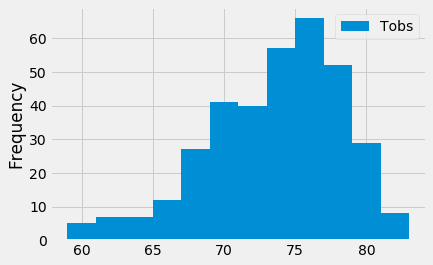

In [63]:
# Choose the station with the highest number of temperature observations.
with_highest_temp = session.execute("select max(tobs), station from measurement").fetchall()

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
this_station = session.execute(f"select date, tobs from measurement where station='{most_active_station[0][1]}' and date > '{prior_year}'").fetchall()

station_df = pd.DataFrame(this_station)

station_df = station_df.rename(columns={0:'Date', 1:'Tobs'})
station_df.plot(kind='hist', bins=12)


![precipitation](Images/station-histogram.png)

In [64]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [65]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

##### 62.0 68.36585365853658 74.0 ######

trip_start_date = '2016-12-28'
trip_end_date = '2017-01-05'
trip_dates = '2016-12-28  2017-01-05'
trip_temp = calc_temps(trip_start_date, trip_end_date )
trip_temp

[(62.0, 69.27272727272727, 77.0)]

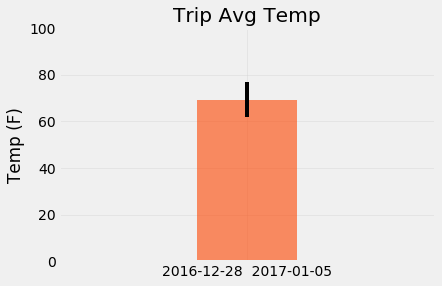

In [66]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

min_temp = trip_temp[0][0]
avg_temp = trip_temp[0][1]
max_temp = trip_temp[0][2]

min_err = avg_temp - min_temp
max_err = max_temp - avg_temp

error_bars = np.array([[min_err], [max_err]])

plt.bar(trip_dates, avg_temp, yerr=error_bars, color = 'orangered', alpha = .6)
plt.ylim(0, 100)
plt.xlim(-1.5, 1.5)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.grid(alpha=.3)


In [120]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
cols = [Station.station, 
         Station.name, 
         func.sum(Measurement.prcp),
         Station.latitude, 
         Station.longitude, 
         Station.elevation]

#rainfall = (session.query(*cols).\

rainfall = (session.query(*cols).\
            filter(Station.station==Measurement.station).\
            filter(Measurement.date >= trip_start_date).\
            filter(Measurement.date <= trip_end_date).\
            group_by(Station.station).\
            order_by(func.sum(Measurement.prcp).desc()).all())



rainfall_df = pd.DataFrame(np.array(rainfall))
rainfall_df = rainfall_df.rename(columns={0:'Station',
                                          1: 'Name',
                                          2: 'Total Rainfall',
                                          3: 'Latitude',
                                          4: 'Longitude',
                                          5: 'Elevation'})
rainfall_df

,Station,Name,Total Rainfall,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",4.94,21.3331,-157.803,152.4
1,USC00513117,"KANEOHE 838.1, HI US",1.39,21.4234,-157.802,14.6
2,USC00519281,"WAIHEE 837.5, HI US",1.25,21.4517,-157.849,32.9
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",1.23,21.5213,-157.837,7
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.78,21.3356,-157.711,19.5
5,USC00519397,"WAIKIKI 717.2, HI US",0.19,21.2716,-157.817,3
6,USC00517948,"PEARL CITY, HI US",None,21.3934,-157.975,11.9


## Optional Challenge Assignment

In [68]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


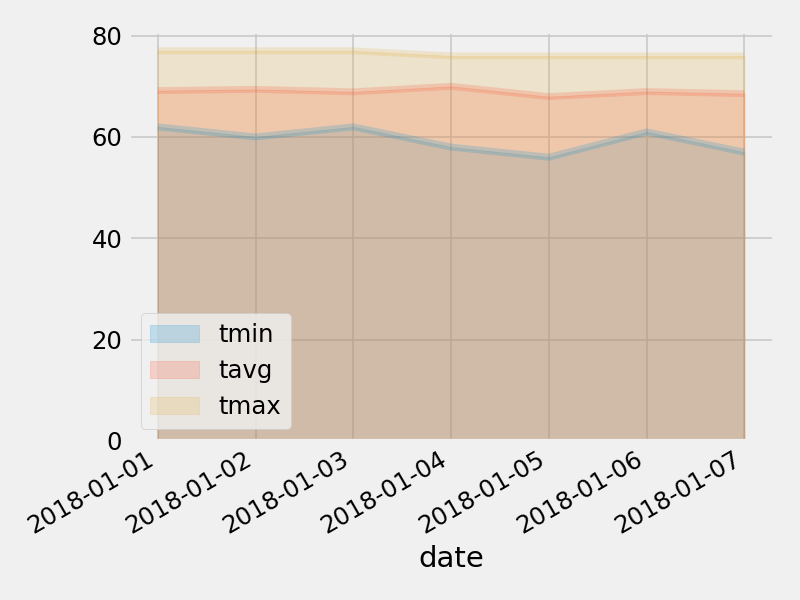

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
